# Huemin Jax Diffusion 2.7
thank you [RiversHaveWings](https://twitter.com/RiversHaveWings) and [nshepperd](https://twitter.com/nshepperd1) for making this all possible <3

In [ ]:
#@markdown Changelog + MIT License
change_log = """
Change Log (last updated 2022.06.03)
- automated stitching
- masked mse (inpainting)
- noise injects
- vitl14 336px
- updated as_cutout_image() to remove grey borders
- fixed print_time_remaining()
- changed run loop to fix resume_stitching and init errors
- added display_init
 """
print(change_log)

# Licensed under the MIT License { display-mode: "form" }

# Copyright (c) 2022 Katherine Crowson; nshepperd; huemin

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [ ]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15109 MiB, 15109 MiB


In [ ]:
#@markdown Default Path Variables:
models_path = "/content/models/" #@param {type:"string"}
output_path = "/content/output/" #@param {type:"string"}
link_path = "/content/link/" #@param {type:"string"}

#@markdown Mount Google Drive (Optional):
mount_google_drive = True #@param {type:"boolean"}
force_remount = False #@param {type:"boolean"}

if mount_google_drive:
  from google.colab import drive
  try:
    drive_path = "/content/drive" #@param {type:"string"}
    drive.mount(drive_path,force_remount=force_remount)
    models_path = "/content/drive/MyDrive/AI/models/" #@param {type:"string"}
    output_path = "/content/drive/MyDrive/AI/JAX/" #@param {type:"string"}
    link_path = "/content/drive/MyDrive/AI/JAX/link/" #@param {type:"string"}
  except:
    print("...error mounting drive or with drive path variables")
    print("...reverting to default path variables")
    models_path = "/content/models/"
    output_path = "/content/output/"
    link_path = "/content/link/"    

!mkdir -p $models_path
!mkdir -p $output_path
!mkdir -p $link_path

print(f"models_path: {models_path}")
print(f"output_path: {output_path}")
print(f"link_path: {link_path}")

Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models/
output_path: /content/drive/MyDrive/AI/JAX/
link_path: /content/drive/MyDrive/AI/JAX/link/


# Parameter Descriptions

Parameter | Description | Values
--- | --- | ---
**Run Settings (Required)**
`seed` | key for pseudo random number generator | `0` for random
`batch_size` | number of images to generate in parallel | `1` recommended 
`batch_folder` | name of the subfolder for saving iamges | `string`
`save_settings` | option to save run settings as .txt file | `True`/`False`
**Diffusion Model Settings (Required)**
`steps` | number of diffusion steps | `integer`
`image_size` | image size in pixels, must be divisible by 64 | `(width,height)`
`diffusion_model` | CC12M (256x256) or OpenAI (512x512) | `choose`
`use_secondary_model` | lowers vram usage and vram quality | `True`/`False`
`sample_mode` | ddim, plms, prk | `choose`
`ddim_eta` | only applies to ddim sample mode | `range -1.0 to 1.0`
`starting_noise` | 1.0 is max noise 0.0 is no noise  | `range 1.0 to 0.0`
`ending_noise` | must be less than starting noise | `range 1.0 to 0.0`
**CLIP Model Settings (Required)**
`use_vitb32` | safe with most gpus | `True`/`False`
`use_vitb16` | safe with most gpus | `True`/`False`
`use_vitl14` | uses more vram | `True`/`False`
`use_vitl14_336px` | uses a lot more vram | `True`/`False`
`all_prompts` | can be text, path, url separate with `\|` add weights with `:` followed by float | `string`
`all_clip_guidance_scale` | applies to each CLIP model | `any number`
**Cut Settings (Required)**
`cutn` | must be integer divisible by 2 | `integer`
`cut_batches` | effective cuts is `cutn` times `cut_batches` | `integer`
`cut_pow` | larger cut_pow smaller the cuts | `range 0.0 to 1.0`
`cut_p_grey` | percentage of greyscale cuts | `range 0.0 to 1.0`
`cut_p_flip` | percentage of flip cuts | `range 0.0 to 1.0`
`cut_p_mixgrey` | percentage of partial greyscale | `range 0.0 to 1.0`
**Conditonal Settings (Required)**
`tv_scale` | more positive means smooth image| `any number`
`range_scale` | more positive means keep pixel values in range | `any number`
`mean_scale` | more positive means closer to grey | `any number`
`var_scale` | more positive means less pixel variation | `any number`
`horizontal_symmetry_scale` | more positive means more horizontal symmetry | `any number`
`vertical_symmetry_scale` | more positive means more vertical symmetry | `any number`
**Multiple Prompt Settings (Optional)**
`use_multiple_prompts` | enables multiple separate prompts | `True`/`False`
`vitb32_all_prompt` | same as `all_prompt` | `string`
`vitb32_clip_guidance_scale` | same as `all_clip_guidance_scale` | `any number`
`vitb16_all_prompt` | same as `all_prompt` | `string`
`vitb16_clip_guidance_scale` | same as `all_clip_guidance_scale` | `any number`
`vitl14_all_prompt` | same as `all_prompt` | `string`
`vitl14_clip_guidance_scale` | same as `all_clip_guidance_scale` | `any number`
`vitl14_336px_all_prompt` | same as `all_prompt` | `string`
`vitl14_336px_clip_guidance_scale` | same as `all_clip_guidance_scale` | `any number`
**Initial Image Settings (Optional)**
`use_init_img` | enables inital image | `True`/`False`
`init_path` | the name or path to an initial image | `string`
`use_mse_img` | enables separate mse image | `True`/`False`
`init_mse_path` | the name or path to an mse image | `string`
`init_mse_scale` | more positive means closer to the mse image | `any number`
`use_masked_mse` | enables inital image mask | `True`/`False`
`init_mse_alpha_path` | the name or path to an alpha mask | `string`
`init_append_path` | path prefix such that `append_path` + `path` = `full_path` | `string`
**Transformation Settings (Optional)**
`use_vertical_symmetry` | enables vertical symmetry transformation | `True`/`False`
`use_horizontal_symmetry` | enables horizontal symmetry transformation | `True`/`False`
`transformation_schedule` | list of percentages from 0.0 to 1.0 specifying when the transformation is performed | `list`
**Noise Inject (Optional)**
`use_noise_inject` | enables noise injects | `True`/`False`
`noise_inject_alpha` | noise inject alpha mask | `string`
`noise_inject_image` | noise inject image | `string`
`noise_inject_scale` | scale noise by factor | `any number`
`noise_inject_symmetry` | make noise inject symmetric | `vertical`/`horizontal`
`noise_inject_schedule` | list of percentages from 0.0 to 1.0 specifying when the inject is performed | `list`
`noise_inject_append_path` | path prefix such that `append_path` + `path` = `full_path` | `string`
**Automated Stitching Settings (Optional)**
`use_automated_stitching` | enable automated stitching | `True`/`False`
`as_init_path` | the name or path to an initial image for automated stitching | `string`
`as_init_append_path` | path prefix such that `append_path` + `path` = `full_path` | `string`
`as_image_size` | automated image size in pixels should be larger than `image_size`, does not need to be divisible by 64 | `(width,height)`
`as_n_pass` | number of automated stitching passes | `positive integer`
`as_image_weight` | weight for stitched image, higher weight means new stitched image will be more visible | `range 0.0 to 1.0`
`as_starting_noise` | same as starting noise just over here for convienience :) | `range 1.0 to 0.0`
`as_init_mse_scale` | mse scale for the automated stitching init image | `any number`
`as_alpha_border` | alpha mask border in pixels | `positive integer`
`as_alpha_feather` | blur factor to apply to alpha mask | `positive integer`
`as_stitch_overlap` | stitching overlap in pixels | `positive integer`
`as_stitch_shift` | schedule for shifting stitching coordinates, should have length equal to `as_n_pass` | `positive integer`






# Setup + Definitions

download repositories and patches

In [ ]:
import os
if os.system("nvidia-smi | grep A100") == 0:
  !pip install -U https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.72+cuda111-cp37-none-manylinux2010_x86_64.whl "jax==0.2.25"
else:
  !pip install https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.1.75%2Bcuda11.cudnn805-cp37-none-manylinux2010_x86_64.whl "jax==0.3.0"
!pip install dm-haiku==0.0.5 cbor2 ftfy einops braceexpand
!git clone https://github.com/enzymezoo-code/CLIP_JAX
!git clone https://github.com/huemin-art/jax-guided-diffusion -b v2.7
!git clone https://github.com/huemin-art/v-diffusion-jax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149.3 MB 11 kB/s 
     |████████████████████████████████| 896 kB 16.1 MB/s 
  Created wheel for jax: filename=jax-0.3.0-py3-none-any.whl size=1037286 sha256=a20bba3becb75982bcefd54a841659a8d8cc6ade2baf378161dc7efa1fc076f8
  Stored in directory: /root/.cache/pip/wheels/e6/69/e5/faee440ee01bacfe78c332c5dd275c69d60e752787c33c0b67
Successfully built jax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.7+cuda11.cudnn805
    Uninstalling jaxlib-0.3.7+cuda11.cudnn805:
      Successfully uninstalled jaxlib-0.3.7+cuda11.cudnn805
  Attempting uninstall: jax
    Found existing installation: jax 0.3.8
    Uninstalling jax-0.3.8:
      Successfully uninstalled jax-0.3.8
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 33.6 MB/s 
     |██████

import python libraries

In [ ]:
import sys, os
sys.path.append('./CLIP_JAX')
sys.path.append('./jax-guided-diffusion')
sys.path.append('./v-diffusion-jax')

import io
import time
import json
import requests
import numpy as np
from subprocess import Popen
from functools import partial

from PIL import Image
from IPython import display

import jax
import jax.numpy as jnp
from jaxtorch import PRNG

import torch
from torch import tensor
from torchvision import utils
from torchvision.transforms import functional as TF

from diffusion_models.schedules import cosine, spliced
from diffusion_models.common import norm1, blur_fft, make_partial
from diffusion_models.lazy import LazyParams
from diffusion_models.perceptor import get_clip, normalize
from diffusion_models.cc12m_1 import cc12m_1_wrap
from diffusion_models.openai import openai_512_finetune
from diffusion_models.secondary import secondary2_wrap
from diffusion_models import sampler

fetch functions

In [ ]:
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    basename = os.path.basename(url_or_path)
    local_path = os.path.join(models_path, basename)
    if os.path.exists(local_path):
        return local_path
    else:
        os.makedirs(f'{models_path}tmp', exist_ok=True)
        Popen(['curl', '--http1.1', url_or_path, '-o', f'{models_path}tmp/{basename}']).wait()
        os.rename(f'{models_path}tmp/{basename}', local_path)
        return local_path

CC12M model parameters

In [ ]:
cc12m_1_params = LazyParams.pt('https://the-eye.eu/public/AI/models/v-diffusion/cc12m_1.pth')
LazyParams.fetch = fetch_model

CLIP cutout functions

In [ ]:
def grey(image):
    [*_, c, h, w] = image.shape
    return jnp.broadcast_to(image.mean(axis=-3, keepdims=True), image.shape)

def cutout_image(image, offsetx, offsety, size, output_size=224):
    """Computes (square) cutouts of an image given x and y offsets and size."""
    (c, h, w) = image.shape

    scale = jnp.stack([output_size / size, output_size / size])
    translation = jnp.stack([-offsety * output_size / size, -offsetx * output_size / size])
    return jax.image.scale_and_translate(image,
                                         shape=(c, output_size, output_size),
                                         spatial_dims=(1,2),
                                         scale=scale,
                                         translation=translation,
                                         method='lanczos3')

def cutouts_images(image, offsetx, offsety, size, output_size=224):
    f = partial(cutout_image, output_size=output_size)         # [c h w] [] [] [] -> [c h w]
    f = jax.vmap(f, in_axes=(0, 0, 0, 0), out_axes=0)          # [n c h w] [n] [n] [n] -> [n c h w]
    f = jax.vmap(f, in_axes=(None, 0, 0, 0), out_axes=0)       # [n c h w] [k n] [k n] [k n] -> [k n c h w]
    return f(image, offsetx, offsety, size)

@jax.tree_util.register_pytree_node_class
class MakeCutouts(object):
    def __init__(self, cut_size, cutn, cut_pow=1.0, p_grey=0.2, p_mixgrey=None, p_flip=0.5):
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.p_grey = p_grey
        self.p_mixgrey = p_mixgrey
        self.p_flip = p_flip

    def __call__(self, input, key):
        [n, c, h, w] = input.shape
        rng = PRNG(key)

        small_cuts = self.cutn//2
        large_cuts = self.cutn - self.cutn//2

        max_size = min(h, w)
        min_size = min(h, w, self.cut_size)
        cut_us = jax.random.uniform(rng.split(), shape=[small_cuts, n])**self.cut_pow
        sizes = (min_size + cut_us * (max_size - min_size)).clamp(min_size, max_size)
        offsets_x = jax.random.uniform(rng.split(), [small_cuts, n], minval=0, maxval=w - sizes)
        offsets_y = jax.random.uniform(rng.split(), [small_cuts, n], minval=0, maxval=h - sizes)
        cutouts = cutouts_images(input, offsets_x, offsets_y, sizes, output_size=self.cut_size)

        B1 = 40
        B2 = 40
        lcut_us = jax.random.uniform(rng.split(), shape=[large_cuts, n])
        border = B1 + lcut_us * B2
        lsizes = (max(h,w) + border).astype(jnp.int32)
        loffsets_x = jax.random.uniform(rng.split(), [large_cuts, n], minval=w/2-lsizes/2-border, maxval=w/2-lsizes/2+border)
        loffsets_y = jax.random.uniform(rng.split(), [large_cuts, n], minval=h/2-lsizes/2-border, maxval=h/2-lsizes/2+border)
        lcutouts = cutouts_images(input, loffsets_x, loffsets_y, lsizes, output_size=self.cut_size)

        cutouts = jnp.concatenate([cutouts, lcutouts], axis=0)

        greyed = grey(cutouts)

        if self.p_mixgrey is not None:
          grey_us = jax.random.uniform(rng.split(), shape=[self.cutn, n, 1, 1, 1])
          grey_rs = jax.random.uniform(rng.split(), shape=[self.cutn, n, 1, 1, 1])
          cutouts = jnp.where(grey_us < self.p_mixgrey, grey_rs * greyed + (1 - grey_rs) * cutouts, cutouts)

        if self.p_grey is not None:
          grey_us = jax.random.uniform(rng.split(), shape=[self.cutn, n, 1, 1, 1])
          cutouts = jnp.where(grey_us < self.p_grey, greyed, cutouts)

        if self.p_flip is not None:
          flip_us = jax.random.bernoulli(rng.split(), self.p_flip, [self.cutn, n, 1, 1, 1])
          cutouts = jnp.where(flip_us, jnp.flip(cutouts, axis=-1), cutouts)

        return cutouts

    def tree_flatten(self):
        return ([self.cut_pow, self.p_grey, self.p_mixgrey, self.p_flip], (self.cut_size, self.cutn))

    @staticmethod
    def tree_unflatten(static, dynamic):
        (cut_size, cutn) = static
        return MakeCutouts(cut_size, cutn, *dynamic)

def spherical_dist_loss(x, y):
    x = norm1(x)
    y = norm1(y)
    return (x - y).square().sum(axis=-1).sqrt().div(2).arcsin().square().mul(2)

@make_partial
def SphericalDistLoss(text_embed, clip_guidance_scale, image_embeds):
    losses = spherical_dist_loss(image_embeds, text_embed).mean(0)
    return (clip_guidance_scale * losses).sum()

process prompt function

In [ ]:
def process_prompt(clip,all_prompt):
  embeds = []
  expands = all_prompt.split("|")
  for prompt in expands:
    prompt = prompt.strip()
    # check url
    if "https:" in prompt:
      tmp = prompt.split(":")
      # check weight
      if len(tmp) == 2:
        temp_weight = 1
        temp_prompt = prompt
        init_pil = Image.open(fetch(temp_prompt))
        tmp_embed = temp_weight * clip.embed_image(init_pil)
        if len(tmp_embed.shape) != 1:
          tmp_embed = tmp_embed[-1]
        embeds.append(tmp_embed)
        #print("here1")
        #print(tmp_embed.shape)
      if len(tmp) == 3:
        temp_prompt = ":".join(tmp[0:2]).strip()
        temp_weight = float(tmp[2].strip())
        init_pil = Image.open(fetch(temp_prompt))
        tmp_embed = temp_weight * clip.embed_image(init_pil)
        if len(tmp_embed.shape) != 1:
          tmp_embed = tmp_embed[-1]
        embeds.append(tmp_embed)
        #print("here2")
        #print(tmp_embed.shape)
    # if not url
    else:
      # check weight
      if ':' in prompt:
        tmp = prompt.split(":")
        temp_prompt = tmp[0].strip()
        temp_weight = float(tmp[1].strip())
      else:
        temp_prompt = prompt
        temp_weight = 1
      # try path
      try:
        init_pil = Image.open(fetch(temp_prompt))
        tmp_embed = temp_weight * clip.embed_image(init_pil)
        if len(tmp_embed.shape) != 1:
          tmp_embed = tmp_embed[-1]
        embeds.append(tmp_embed)
      except:
        tmp_embed = temp_weight * clip.embed_text(temp_prompt.strip())
        embeds.append(tmp_embed)
        #print("here4")
        #print(tmp_embed.shape)
  return norm1(sum(embeds))

def process_prompts(clip, prompts):
  return jnp.stack([process_prompt(clip, prompt) for prompt in prompts])

def expand(xs, batch_size):
  """Extend or truncate the list of prompts to the batch size."""
  return (xs * batch_size)[:batch_size]

conditional functions

In [ ]:
@jax.tree_util.register_pytree_node_class
class MainCondFn(object):
    # Used to construct the main cond_fn. Accepts a diffusion model which will
    # be used for denoising, plus a list of 'conditions' which will
    # generate gradient of a loss wrt the denoised, to be summed together.
    def __init__(self, diffusion, conditions, blur_amount=None, use='pred'):
        self.diffusion = diffusion
        self.conditions = [c for c in conditions if c is not None]
        self.blur_amount = blur_amount
        self.use = use

    @jax.jit
    def __call__(self, x, cosine_t, key):
        if not self.conditions:
          return jnp.zeros_like(x)

        rng = PRNG(key)
        n = x.shape[0]

        alphas, sigmas = cosine.to_alpha_sigma(cosine_t)

        def denoise(key, x):
            pred = self.diffusion(x, cosine_t, key).pred
            if self.use == 'pred':
                return pred
            elif self.use == 'x_in':
                return pred * sigmas + x * alphas
        (x_in, backward) = jax.vjp(partial(denoise, rng.split()), x)

        total = jnp.zeros_like(x_in)
        for cond in self.conditions:
            total += cond(x_in, rng.split())
        if self.blur_amount is not None:
          blur_radius = (self.blur_amount * sigmas / alphas).clamp(0.05,512)
          total = blur_fft(total, blur_radius.mean())
        final_grad = -backward(total)[0]

        # clamp gradients to a max of 0.2
        magnitude = final_grad.square().mean(axis=(1,2,3), keepdims=True).sqrt()
        final_grad = final_grad * jnp.where(magnitude > 0.2, 0.2 / magnitude, 1.0)
        return final_grad
    def tree_flatten(self):
        return [self.diffusion, self.conditions, self.blur_amount], [self.use]
    def tree_unflatten(static, dynamic):
        return MainCondFn(*dynamic, *static)

def filternone(xs):
  return [x for x in xs if x is not None]

@jax.tree_util.register_pytree_node_class
class CondCLIP(object):
    """Backward a loss function through clip."""
    def __init__(self, perceptor, make_cutouts, cut_batches, *losses):
        self.perceptor = perceptor
        self.make_cutouts = make_cutouts
        self.cut_batches = cut_batches
        self.losses = filternone(losses)
    def __call__(self, x_in, key):
        n = x_in.shape[0]
        def main_clip_loss(x_in, key):
            cutouts = normalize(self.make_cutouts(x_in.add(1).div(2), key)).rearrange('k n c h w -> (k n) c h w')
            image_embeds = self.perceptor.embed_cutouts(cutouts).rearrange('(k n) c -> k n c', n=n)
            return sum(loss_fn(image_embeds) for loss_fn in self.losses)
        num_cuts = self.cut_batches
        keys = jnp.stack(jax.random.split(key, num_cuts))
        main_clip_grad = jax.lax.scan(lambda total, key: (total + jax.grad(main_clip_loss)(x_in, key), key),
                                        jnp.zeros_like(x_in),
                                        keys)[0] / num_cuts
        return main_clip_grad
    def tree_flatten(self):
        return [self.perceptor, self.make_cutouts, self.losses], [self.cut_batches]
    @classmethod
    def tree_unflatten(cls, static, dynamic):
        [perceptor, make_cutouts, losses] = dynamic
        [cut_batches] = static
        return cls(perceptor, make_cutouts, cut_batches, *losses)

@make_partial
def CondTV(tv_scale, x_in, key):
    def downscale2d(image, f):
        [c, n, h, w] = image.shape
        return jax.image.resize(image, [c, n, h//f, w//f], method='cubic')

    def tv_loss(input):
        """L2 total variation loss, as in Mahendran et al."""
        x_diff = input[..., :, 1:] - input[..., :, :-1]
        y_diff = input[..., 1:, :] - input[..., :-1, :]
        return x_diff.square().mean([1,2,3]) + y_diff.square().mean([1,2,3])

    def sum_tv_loss(x_in, f=None):
        if f is not None:
            x_in = downscale2d(x_in, f)
        return tv_loss(x_in).sum() * tv_scale
    tv_grad_512 = jax.grad(sum_tv_loss)(x_in)
    tv_grad_256 = jax.grad(partial(sum_tv_loss,f=2))(x_in)
    tv_grad_128 = jax.grad(partial(sum_tv_loss,f=4))(x_in)
    return tv_grad_512 + tv_grad_256 + tv_grad_128

@make_partial
def CondRange(range_scale, x_in, key):
    def range_loss(x_in):
        return jnp.abs(x_in - x_in.clamp(minval=-1,maxval=1)).mean()
    return range_scale * jax.grad(range_loss)(x_in)

@make_partial
def CondMean(mean_scale, x_in, key):
    def mean_loss(x_in):
        return jnp.abs(x_in).mean()
    return mean_scale * jax.grad(mean_loss)(x_in)

@make_partial
def CondVar(var_scale, x_in, key):
    def var_loss(x_in):
        return x_in.var()
    return var_scale * jax.grad(var_loss)(x_in)

@make_partial
def CondHorizontalSymmetry(horizontal_symmetry_scale, x_in, key):
    def horizontal_symmetry_loss(x_in):
        [n, c, h, w] = x_in.shape
        return jnp.abs(x_in[:, :, :, :w//2]-jnp.flip(x_in[:, :, :, w//2:],-1)).mean()
    return horizontal_symmetry_scale * jax.grad(horizontal_symmetry_loss)(x_in)

@make_partial
def CondVerticalSymmetry(vertical_symmetry_scale, x_in, key):
    def vertical_symmetry_loss(x_in):
        [n, c, h, w] = x_in.shape
        return jnp.abs(x_in[:, :, :h//2, :]-jnp.flip(x_in[:, :, h//2:, :],-2)).mean()
    return vertical_symmetry_scale * jax.grad(vertical_symmetry_loss)(x_in)

@make_partial
def CondMSE(target, mse_scale, x_in, key):
    def mse_loss(x_in):
        return (x_in - target).square().mean()
    return mse_scale * jax.grad(mse_loss)(x_in)

@make_partial
def CondMaskedMSE(target, mse_scale, mask, x_in, key):
    def mse_loss(x_in):
        return (mask * (x_in - target).square()).mean()
    return mse_scale * jax.grad(mse_loss)(x_in)

QoL functions

In [ ]:
def display_images(images):
  images = images.add(1).div(2).clamp(0, 1)
  images = torch.tensor(np.array(images))
  grid = utils.make_grid(images, 4).cpu()
  display.display(TF.to_pil_image(grid))
  return

def load_image(url,image_size,resize=True):
    init_array = Image.open(fetch(url)).convert('RGB')
    if resize:
      init_array = init_array.resize(image_size, Image.LANCZOS)
    init_array = jnp.array(TF.to_tensor(init_array)).unsqueeze(0).mul(2).sub(1)
    return init_array

def get_output_folder(output_path,batch_folder=None):
  yearMonth = time.strftime('%Y-%m/')
  out_path = output_path+yearMonth
  if batch_folder != "":
    out_path += batch_folder
    if out_path[-1] != "/":
      out_path += "/"
  os.makedirs(out_path, exist_ok=True)
  return out_path

def print_time_remaining():
  tmp = toc - tic
  mult_total = as_n_pass*len(x_schedule)*len(y_schedule)
  mult_complete = nn*len(x_schedule)*len(y_schedule)+ix*len(y_schedule)+iy+1
  #print(f"mult_total: {mult_total} mult_complete: {mult_complete}")
  mult = mult_total - mult_complete
  tmp = tmp*mult
  if tmp < 60:
    unit = 's'
  elif tmp < 60*60:
    unit = 'mins'
    tmp = tmp/60
  elif tmp < 60*60*24:
    unit = 'hrs'
    tmp = tmp/(60*60)
  print(f"...estimated time remaining {tmp:0.2f} {unit}")
  return

def strip_weights_from_prompt(all_prompt):
  stripped_prompt = []
  expands = all_prompt.split("|")
  for prompt in expands:
    prompt = prompt.strip()
    if "https:" in prompt:
      tmp = prompt.split(":")
      if len(tmp) == 2:
        stripped_prompt.append(prompt)
      if len(tmp) == 3:
        temp_prompt = ":".join(tmp[0:2]).strip()
        temp_prompt = ":".join(tmp[0:2]).strip()+" :"+tmp[2].strip()
        stripped_prompt.append(temp_prompt)
    else:
      stripped_prompt.append(prompt)

  return(" | ".join(stripped_prompt))


AR functions

In [ ]:
@jax.tree_util.register_pytree_node_class
class asMakeCutouts(object):
    def __init__(self, cut_size, cutn):
        self.cut_size = cut_size
        self.cutn = cutn

    def __call__(self, input, key):
        [n, c, h, w] = input.shape
        rng = PRNG(key)

        cut_us = jnp.ones((self.cutn,1))
        sizes = (cut_us * self.cut_size).clamp(self.cut_size)
        offsets_x = jax.random.randint(rng.split(), [self.cutn, n], minval=-self.cut_size//2, maxval=w-self.cut_size//2)
        offsets_y = jax.random.randint(rng.split(), [self.cutn, n], minval=-self.cut_size//2, maxval=h-self.cut_size//2)
        print(offsets_x)
        print(offsets_y)
        print(sizes)
        cutouts = cutouts_images(input, offsets_x, offsets_y, sizes, output_size=self.cut_size)

        return cutouts, offsets_x, offsets_y

    def tree_flatten(self):
        return ((self.cut_size, self.cutn))

    @staticmethod
    def tree_unflatten(static, dynamic):
        (cut_size, cutn) = static
        return asMakeCutouts(cut_size, cutn, *dynamic)

def as_cutout_image(as_image, offsetx, offsety, image_size):
    c, h, w = as_image[0].shape
    scale = jnp.stack([1,1])
    translation = jnp.stack([-offsety, -offsetx])
    as_cuts = jax.image.scale_and_translate(as_image[0],
                                         shape=(c, image_size[1], image_size[0]),
                                         spatial_dims=(1,2),
                                         scale=scale,
                                         translation=translation,
                                         method='lanczos3')
    
    try:
      if offsetx+(image_size[0]/2) <= 0:
        error_code = 1
        as_cuts = as_cuts.at[:,:,2*(-image_size[0]-offsetx):-image_size[0]-offsetx].set(jnp.flip(as_cuts[:,:,-image_size[0]-offsetx:],-1))
      elif offsetx < 0:
        error_code = 2
        as_cuts = as_cuts.at[:,:,:-1*offsetx].set(jnp.flip(as_cuts[:,:,-1*offsetx:-2*offsetx],-1))
      if offsety+(image_size[1]/2) <= 0:
        error_code = 3
        as_cuts = as_cuts.at[:,2*(-image_size[1]-offsety):-image_size[1]-offsety,:].set(jnp.flip(as_cuts[:,-image_size[1]-offsety:,:],-2))
      elif offsety < 0:
        error_code = 4
        as_cuts = as_cuts.at[:,:-1*offsety,:].set(jnp.flip(as_cuts[:,-1*offsety:-2*offsety,:],-2))
      if offsetx+(image_size[0]/2) >= w:
        error_code = 5
        as_cuts = as_cuts.at[:,:,w-offsetx:2*(w-offsetx)].set(jnp.flip(as_cuts[:,:,:w-offsetx],-1))
      elif offsetx+image_size[0] > w:
        error_code = 6
        as_cuts = as_cuts.at[:,:,image_size[0]-offsetx:].set(jnp.flip(as_cuts[:,:,2*(image_size[0]-offsetx):image_size[0]-offsetx],-1))
      if offsety+(image_size[1]/2) >= h:
        error_code = 7
        as_cuts = as_cuts.at[:,h-offsety:2*(h-offsety),:].set(jnp.flip(as_cuts[:,:h-offsety,:],-2))
      elif offsety+image_size[1] > h:
        error_code = 8
        as_cuts = as_cuts.at[:,image_size[1]-offsety:,:].set(jnp.flip(as_cuts[:,2*(image_size[1]-offsety):image_size[1]-offsety,:],-2))
    except:
      print(f"...as_cutout_image() error code {error_code}")

    return as_cuts

def create_as_alpha(image_size,border,blur_std):
  if border > min(image_size):
    print("border greater than image dimensions")
  if border < 0:
    print("border should not be negative")
  ar_alpha = jnp.ones((1,3,image_size[1],image_size[0])).clamp(0,1)
  ar_alpha = ar_alpha.at[:,:,:border,:].set(-1*ar_alpha[:,:,:border,:])
  ar_alpha = ar_alpha.at[:,:,image_size[1]-border:,:].set(-1*ar_alpha[:,:,image_size[1]-border:,:])
  ar_alpha = ar_alpha.at[:,:,border:image_size[1]-border,:border].set(-1*ar_alpha[:,:,border:image_size[1]-border,:border])
  ar_alpha = ar_alpha.at[:,:,border:image_size[1]-border,image_size[0]-border:].set(-1*ar_alpha[:,:,border:image_size[1]-border,image_size[0]-border:])
  ar_alpha = blur_fft(ar_alpha,blur_std)
  return ar_alpha

def create_as_offsets(image_size,ar_image_size,overlap_border):
  w, h, ar_w, ar_h = image_size[0], image_size[1], ar_image_size[0], ar_image_size[1]
  tmp_w = ar_w+overlap_border
  tmp_h = ar_h+overlap_border
  tmp_x = -overlap_border
  tmp_y = -overlap_border
  x_offsets = [tmp_x]
  y_offsets = [tmp_y]
  while (tmp_x+image_size[0]-overlap_border) < ar_image_size[0]:
    tmp_x += image_size[0]-overlap_border
    x_offsets.append(tmp_x)
  while (tmp_y+image_size[1]-overlap_border) < ar_image_size[1]:
    tmp_y += image_size[1]-overlap_border
    y_offsets.append(tmp_y)
  return x_offsets, y_offsets

transformation and noise settings

In [ ]:
def vertical_symmetry(x_in):
  [n, c, h, w] = x_in.shape
  return jnp.concatenate([x_in[:, :, :h//2, :], jnp.flip(x_in[:, :, :h//2, :],-2)], -2)

def horizontal_symmetry(x_in):
  [n, c, h, w] = x_in.shape
  return jnp.concatenate([x_in[:, :, :, :w//2], jnp.flip(x_in[:, :, :, :w//2],-1)], -1)

def inject_noise(x_in,img_in,noise_alpha,noise_scale,noise_symmetry):

  # load img
  tmp = load_image(img_in,image_size)

  # make noise
  noise = jax.random.normal(rng.split(), [batch_size, 3, image_size[1], image_size[0]])

  # add noise to img
  noise = (noise*noise_scale)+tmp

  # force noise to have symmetry
  if noise_symmetry == "vertical":
    noise = vertical_symmetry(noise)
  
  if noise_symmetry == "horizontal":
    noise = horizontal_symmetry(noise)

  # noise type
  mask = load_image(noise_alpha,image_size)

  # apply mask to noise
  inject  = noise*(mask.add(1).div(2))

  # apply inverse mask to x
  x_in = x_in*(mask.mul(-1).add(1).div(2))

  return x_in + inject


def x_transformation(x,t):
  if use_horizontal_symmetry:
    if t in t_schedule:
      x = horizontal_symmetry(x)
      print(" horizontal symmetry applied")
  if use_vertical_symmetry:
    if t in t_schedule:
      x = vertical_symmetry(x)
      print(" vertical symmetry applied")
  if use_noise_inject:
    if t in n_schedule:
      n_index = n_schedule.index(t)
      n_image = noise_inject_image_s[n_index]
      n_alpha = noise_inject_alpha_s[n_index]
      n_scale = noise_inject_scale[n_index]
      n_symmetry = noise_inject_symmetry[n_index]
      x = inject_noise(x,n_image,n_alpha,n_scale,n_symmetry)
      print(" noise inject")
  return x

# Run Settings (Required)

In [ ]:
def req_params():

 #@markdown Run Settings (Required)
 #seed - used to determine 
  seed = 0 #@param
  batch_size = 4 #@param {type:"integer"}
  batch_folder = "test" #@param {type:"string"}
  save_settings = "end of render" #@param ["end of render","beginning of render"]
  #@markdown Diffusion Model Settings (Required)
  steps =  100#@param {type:"integer"}
  image_size = (256,256) #@param
  diffusion_model = "CC12M" #@param ["OpenAIFinetune", "CC12M"]
  use_secondary_model = False #@param {type:"boolean"}
  sample_mode = 'ddim' #@param ["ddim", "plms", "prk"]
  ddim_eta = 0.5 #@param
  starting_noise =  1.0#@param
  ending_noise = 0.0 #@param
  #@markdown CLIP Model Settings (Required)
  use_vitb32 = True #@param {type:"boolean"}
  use_vitb16 = True #@param {type:"boolean"}
  use_vitl14 = False #@param {type:"boolean"}
  use_vitl14_336px = False #@param {type:"boolean"}
  all_prompts = "scifi abstract geometric pattern | white:-1 |  https://uploads6.wikiart.org/images/salvador-dali/the-persistence-of-memory-1931.jpg!Large.jpg:0.01" #@param {type:"string"}
  all_clip_guidance_scale = 80000 #@param {type:"integer"}
  #@markdown Cut Settings (Required)
  cutn = 4 #@param {type:"integer"}
  cut_batches =  4#@param {type:"integer"}
  cut_pow = 1.0 #@param
  cut_p_grey = 0.2 #@param
  cut_p_flip = 0.5 #@param
  cut_p_mixgrey = None #@param
  #@markdown Conditonal Settings (Required)
  tv_scale = 100 #@param {type:"integer"}
  range_scale = 100 #@param {type:"integer"}
  mean_scale = 100 #@param {type:"integer"}
  var_scale =   100#@param {type:"integer"}
  horizontal_symmetry_scale = 0 #@param {type:"integer"}
  vertical_symmetry_scale = 0 #@param {type:"integer"}
  return locals()

params = req_params()
globals().update(params)

# prevent errors
try:
  print(f"use_init_img: {use_init_img}")
except NameError:
  use_init_img = False
  print(f"use_init_img: {use_init_img}")

try:
  print(f"use_batch_runs: {use_batch_runs}")
except NameError:
  use_batch_runs = False
  print(f"use_batch_runs: {use_batch_runs}")

try:
  print(f"init_mse_scale: {init_mse_scale}")
except NameError:
  init_mse_scale = False
  print(f"init_mse_scale: {init_mse_scale}")

try:
  print(f"use_masked_mse: {use_masked_mse}")
except NameError:
  use_masked_mse = False
  print(f"use_masked_mse: {use_masked_mse}")
  
try:
  print(f"use_noise_inject: {use_noise_inject}")
except NameError:
  use_noise_inject = False
  print(f"use_noise_inject: {use_noise_inject}")

try:
  print(f"save_batch_settings: {save_batch_settings}")
except NameError:
  save_batch_settings = False
  print(f"save_batch_settings: {save_batch_settings}")

try:
  print(f"use_random_settings: {use_random_settings}")
except NameError:
  use_random_settings = False
  print(f"use_random_settings: {use_random_settings}")

try:
  print(f"use_multiple_prompts: {use_multiple_prompts}")
except NameError:
  use_multiple_prompts = False
  print(f"use_multiple_prompts: {use_multiple_prompts}")

try:
  print(f"use_vertical_symmetry: {use_vertical_symmetry}")
except NameError:
  use_vertical_symmetry = False
  print(f"use_vertical_symmetry: {use_vertical_symmetry}")

try:
  print(f"use_automated_stitching: {use_automated_stitching}")
except NameError:
  use_automated_stitching = False
  print(f"use_automated_stitching: {use_automated_stitching}")

try:
  print(f"use_horizontal_symmetry: {use_horizontal_symmetry}")
except NameError:
  use_horizontal_symmetry = False
  print(f"use_horizontal_symmetry: {use_horizontal_symmetry}")


use_init_img: False
use_batch_runs: False
init_mse_scale: False
use_masked_mse: False
use_noise_inject: False
save_batch_settings: False
use_random_settings: False
use_multiple_prompts: False
use_vertical_symmetry: False
use_automated_stitching: False
use_horizontal_symmetry: False


# More Settings (Optional)

In [ ]:
def opt_params():
  #@markdown Multiple Prompt Settings (Optional)
  use_multiple_prompts = False #@param {type:"boolean"}
  vitb32_all_prompt = "scifi abstract geometric pattern | white:-1" #@param {type:"string"}
  vitb32_clip_guidance_scale = 120000 #@param {type:"integer"}
  vitb16_all_prompt = "https://uploads6.wikiart.org/images/salvador-dali/the-persistence-of-memory-1931.jpg!Large.jpg" #@param {type:"string"}
  vitb16_clip_guidance_scale = 40000 #@param {type:"integer"}
  vitl14_all_prompt = "" #@param {type:"string"}
  vitl14_clip_guidance_scale = 0 #@param {type:"integer"}
  vitl14_336px_all_prompt = "" #@param {type:"string"}
  vitl14_336px_clip_guidance_scale = 0 #@param {type:"integer"}
  #@markdown Initial Image Settings (Optional)
  use_init_img = False #@param {type:"boolean"}
  use_masked_mse = False #@param {type:"boolean"}
  init_starting_noise = 0.70 #@param
  init_path = "init01.png" #@param {type:"string"}
  init_mse_alpha_path = "alpha01.png" #@param {type:"string"}
  init_append_path = link_path #@param
  init_mse_scale = 1000 #@param {type:"integer"}
  #@markdown Transformation Settings (Optional)
  use_vertical_symmetry = False #@param {type:"boolean"}
  use_horizontal_symmetry = False #@param {type:"boolean"}
  transformation_schedule = [0.1,0.2,0.3] #@param
  #@markdown Noise Inject (Optional)
  use_noise_inject = False #@param {type:"boolean"}
  noise_inject_alpha = ["alpha01.png"] #@param
  noise_inject_image = ["inject01.png"] #@param
  noise_inject_scale = [1] #@param
  noise_inject_symmetry = ["vertical"] #@param
  noise_inject_schedule = [0.2] #@param
  noise_inject_append_path = link_path #@param
  #@markdown Automated Stitching Settings (Optional)
  use_automated_stitching = False #@param {type:"boolean"}
  use_as_init_img = True
  as_init_path = "https://uploads6.wikiart.org/images/salvador-dali/the-persistence-of-memory-1931.jpg!Large.jpg" #@param {type:"string"}
  as_init_append_path = "" #@param
  as_image_size = (512,512) #@param
  as_n_pass =  2 #@param
  as_image_weight = 0.90 #@param
  as_starting_noise = 0.60 #@param
  as_init_mse_scale =  100000#@param
  as_alpha_border = 16 #@param
  as_alpha_feather =  8 #@param
  as_stitch_overlap = 64 #@param
  as_stitch_shift = [0,-16] #@param
  if (use_automated_stitching and use_as_init_img):
    use_init_img = False
    init_path = ""
    init_mse_scale = as_init_mse_scale
  if use_init_img:
    starting_noise = init_starting_noise
  if use_automated_stitching:
    starting_noise = as_starting_noise
  return locals()

tmp_params = opt_params()
params.update(tmp_params)
globals().update(tmp_params)

In [ ]:
#@markdown Test Automated Stitching
tmp_path = "/content/tmp/"
!mkdir -p $tmp_path

as_img = -1*jnp.ones((1,3,as_image_size[1],as_image_size[0]))
as_alpha = create_as_alpha(image_size,as_alpha_border,as_alpha_feather)
x_schedule, y_schedule = create_as_offsets(image_size,as_image_size,as_stitch_overlap)

as_n_frame = 0
as_max_frame = as_n_pass*len(x_schedule)*len(y_schedule)

for nn in range(as_n_pass):
  for xx in x_schedule:
    for yy in y_schedule:

        if nn > (len(as_stitch_shift)-1):
          shift = np.random.choice(as_stitch_shift,1)[0]
        else:
          shift = as_stitch_shift[nn]

        #print(xx,yy)
        as_cuts = as_cutout_image(as_img, xx+shift, yy+shift, image_size)

        w1 = xx+shift
        w2 = xx+shift+image_size[0]
        h1 = yy+shift
        h2 = yy+shift+image_size[1]

        w1_diff = 0
        w2_diff = image_size[0]
        h1_diff = 0
        h2_diff = image_size[1]

        if w1 < 0:
          w1_diff = 0 - w1
        if w2 > as_image_size[0]:
          w2_diff = image_size[0]-(w2-as_image_size[0])

        if h1 < 0:
          h1_diff = 0 - h1
        if h2 > as_image_size[1]:
          h2_diff = image_size[1]-(h2-as_image_size[1])

        as_pred = jnp.ones((1,3,image_size[1],image_size[0]))
        as_pred = ((as_cuts.add(1).div(2)*(1-as_alpha.add(1).div(2)))+(as_pred.add(1).div(2)*as_alpha.add(1).div(2))).mul(2).sub(1)
        as_pred = as_cuts*(1-as_image_weight)+as_pred*as_image_weight
        as_img = as_img.at[:,:,h1+h1_diff:h2+(image_size[1]-h2_diff),w1+w1_diff:w2+(image_size[0]-w2_diff)].set(as_pred[:,:,h1_diff:h2_diff,w1_diff:w2_diff])
        
        #print("cut")
        #display_images(as_cuts)
        #print("pred")
        #display_images(as_pred)
        #display_images(ar_img)

        images = as_img.add(1).div(2).clamp(0, 1)
        images = torch.tensor(np.array(images))
        pil_image = TF.to_pil_image(images[0])
        pil_image.save(f'{tmp_path}test_{str(as_n_frame).zfill(len(str(as_max_frame)))}.png')
        as_n_frame += 1

import glob
import subprocess
from base64 import b64encode

init_frame = 0
last_frame = as_max_frame
fps = 6
image_path = f"{tmp_path}test_%0{len(str(as_max_frame))}d.png"
filepath = f"{tmp_path}test.mp4"

cmd = [
      'ffmpeg',
      '-y',
      '-vcodec',
      'png',
      '-r',
      str(fps),
      '-start_number',
      str(init_frame),
      '-i',
      image_path,
      '-frames:v',
      str(last_frame),
      '-c:v',
      'libx264',
      '-vf',
      f'fps={fps}',
      '-pix_fmt',
      'yuv420p',
      '-crf',
      '17',
      '-preset',
      'veryslow',
      filepath
      ]

process = subprocess.Popen(cmd, cwd=f'{tmp_path}', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
  print(stderr)
  raise RuntimeError(stderr)
else:
  pass

mp4 = open(filepath,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
      <video width=400 controls>
            <source src="%s" type="video/mp4">
      </video>
      """ % data_url)


# Batch Settings (Optional)

In [ ]:
def batch_params():

  #@markdown Batch Run Settings (Optional)
  use_batch_runs = False #@param {type:"boolean"}
  n_batch_runs = 2 #@param {type:"integer"}
  
  #@markdown Batch Random Settings (Optional)
  use_random_settings = False #@param {type:"boolean"}

  #@markdown Batch Initial Image Settings (Optional)
  use_random_init = False #@param {type:"boolean"}
  use_ordered_init = False #@param {type:"boolean"}
  batch_init_path = "" #@param {type:"string"}
  batch_init_append_path = link_path #@param

  #@markdown Batch Random Prompts (Optional)
  use_random_prompts = False #@param {type:"boolean"}
  prompts_path = "prompts.csv" #@param {type:"string"}
  prompt_append_path = link_path #@param

  return locals()

tmp_params = batch_params()
params.update(tmp_params)
globals().update(params)

# batch functions
if use_batch_runs:
  batch_all_prompts = [all_prompts]*n_batch_runs

def random_settings():
  
  def rand_func(minval,maxval):
    randval = np.random.randint(minval,maxval)
    return(randval)

  steps = rand_func(100,200)
  eta = rand_func(-5,10)/10.0
  clip_guidance_scale = rand_func(1000,100000)
  tv_scale = rand_func(0,10000)
  range_scale = rand_func(0,1000)
  mean_scale = rand_func(-1000,1000)
  var_scale = rand_func(-1000,1000)
  horizontal_symmetry_scale = rand_func(-10000,10000)
  vertical_symmetry_scale = rand_func(-10000,10000)

  globals().update(locals())
  return

def get_random_prompts(n_batch_runs):
  import pandas as pd
  prompts = pd.read_csv(prompt_append_path+prompts_path)
  batch_all_prompts = []
  for ii in range(n_batch_runs):
    temp = prompts.prompt.sample(1).item()
    random_prompt_template = f"{temp}" #@param
    batch_all_prompts.append(random_prompt_template)
  return batch_all_prompts

if use_random_prompts:
  batch_all_prompts = get_random_prompts(n_batch_runs)

def get_batch_prompts(n_batch_runs):
  import pandas as pd

  if (use_random_init) or (use_ordered_init):
    try:
      ext = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
      filenames = []
      for filename in os.listdir(batch_init_append_path+batch_init_path):
        if os.path.splitext(filename)[1].lower() in ext:
          filenames.append(filename)
      file_df = pd.DataFrame({"init_filenames":sorted(filenames)})
      #print(file_df)
    except:
      print("...path error")

  if use_random_init:
    batch_init_paths = []
    for i in range(n_batch_runs):
      batch_init_paths.append(batch_init_append_path+batch_init_path+file_df.sample(1).values[0][0])

  if use_ordered_init:
    batch_init_paths = []
    n_batch_runs = len(file_df)
    for i in range(n_batch_runs):
      batch_init_paths.append(batch_init_append_path+batch_init_path+file_df.loc[i].values[0])

  return batch_init_paths, n_batch_runs

if (use_random_init) or (use_ordered_init):
  batch_init_paths, n_batch_runs = get_batch_prompts(n_batch_runs)

Batch Prompt Override

In [ ]:
if use_batch_runs:
  batch_all_prompts = ["scifi abstract geometric pattern | white:-1 | https://uploads6.wikiart.org/images/salvador-dali/the-persistence-of-memory-1931.jpg!Large.jpg:0.01",
                       "scifi abstract geometric pattern | white:-1 | blue:-1 | https://uploads6.wikiart.org/images/salvador-dali/the-persistence-of-memory-1931.jpg!Large.jpg:0.01",
                       "scifi abstract geometric pattern | white:-1 | red:-1 | https://uploads6.wikiart.org/images/salvador-dali/the-persistence-of-memory-1931.jpg!Large.jpg:0.01",
                       "scifi abstract geometric pattern | white:-1 | colorful:-1 | https://uploads6.wikiart.org/images/salvador-dali/the-persistence-of-memory-1931.jpg!Large.jpg:0.01"
                      ]

  n_batch_runs = len(batch_all_prompts)

# Run

...starting run
...scifi abstract geometric pattern | white:-1 | https://uploads6.wikiart.org/images/salvador-dali/the-persistence-of-memory-1931.jpg!Large.jpg :0.01


100%|███████████████████████████████████████| 351M/351M [00:06<00:00, 53.9MiB/s]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|███████████████████████████████████████| 354M/354M [00:13<00:00, 26.5MiB/s]
 40%|████      | 40/100 [04:53<03:58,  3.98s/it]

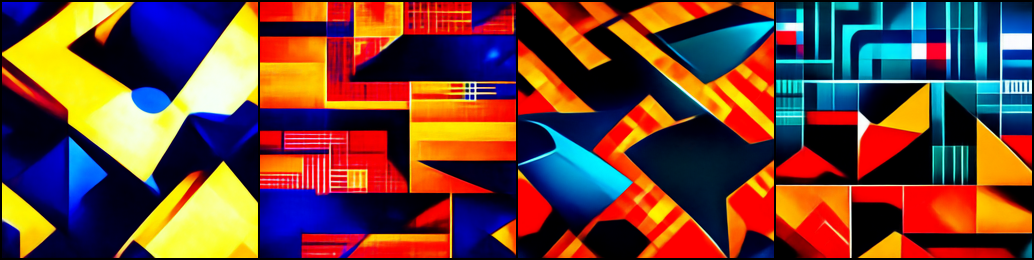

 50%|█████     | 50/100 [05:34<03:22,  4.04s/it]

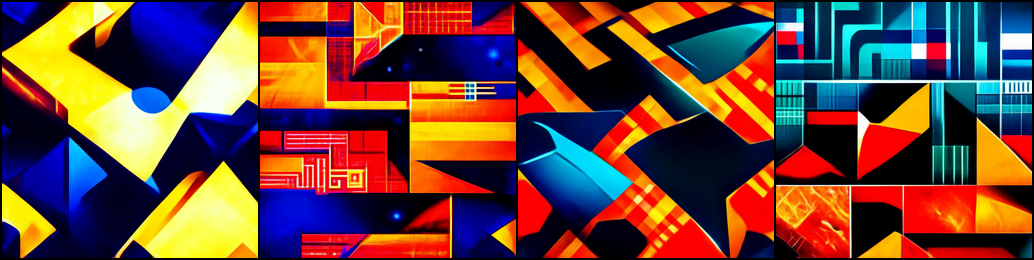

 60%|██████    | 60/100 [06:15<02:43,  4.08s/it]

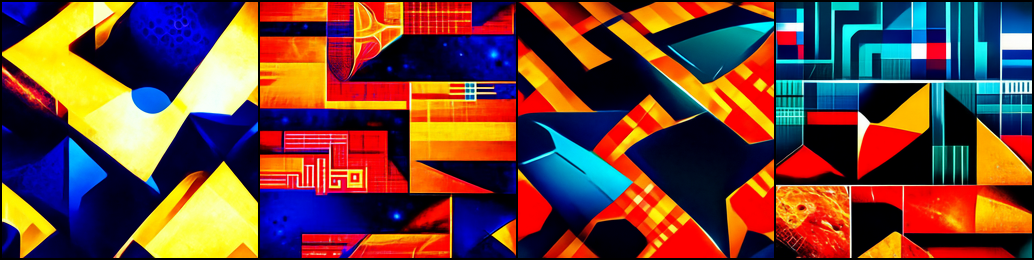

 80%|████████  | 80/100 [07:37<01:22,  4.13s/it]

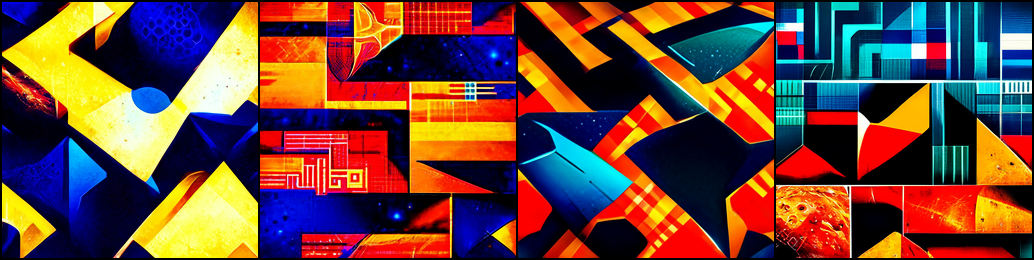

100%|██████████| 100/100 [09:00<00:00,  5.41s/it]


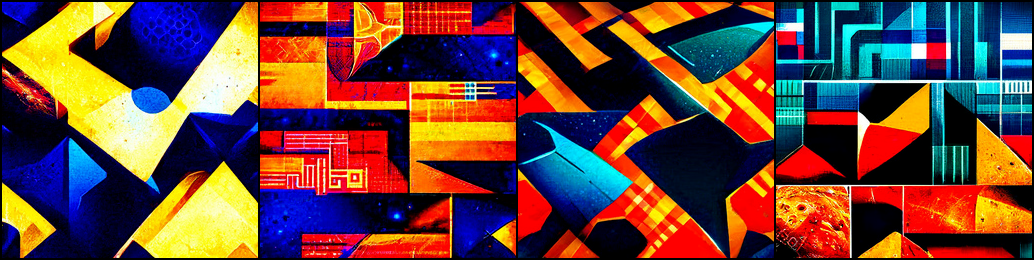

In [ ]:
from torch._C import parse_schema
#@markdown Display Init
display_init = True #@param {type:"boolean"}

#@markdown Display Rate
save_rates = False #@param {type:"boolean"}
display_rates = True #@param {type:"boolean"}
rate = 50 #@param {type:"integer"}

#@markdown Display Percent
save_percents = False #@param {type:"boolean"}
display_percents = True #@param {type:"boolean"}
percent_schedule = [0.4,0.6,0.8] #@param

#@markdown Automated Stitching
save_intermediate_steps = False #@param {type:"boolean"}
resume_automated_stitching = False #@param {type:"boolean"}
use_display_as_cuts = True #@param {type:"boolean"}
use_display_as_pred = True #@param {type:"boolean"}
use_display_as_img = True #@param {type:"boolean"}


def config():

  # clip
  vitb16 = lambda: get_clip('ViT-B/16')
  vitb32 = lambda: get_clip('ViT-B/32')
  vitl14 = lambda: get_clip('ViT-L/14')
  vitl14_336px = lambda: get_clip('ViT-L/14@336px')

  # diffusion
  if diffusion_model == 'OpenAIFinetune':
    diffusion = openai_512_finetune()
  if diffusion_model == 'CC12M':
    diffusion = cc12m_1_wrap(cc12m_1_params(), clip_embed=process_prompts(vitb16(), title))
  if diffusion_model == 'CC12M_Danbooru':
    diffusion = cc12m_1_wrap(cc12m_danbooru_params(), clip_embed=process_prompts(vitb16(), title))

  # secondary
  if use_secondary_model:
    cond_model = secondary2_wrap()
  else:
    cond_model = diffusion

  # cuts
  if use_vitb16 or use_vitb32 or use_vitl14:
    make_cutouts = MakeCutouts(224, cutn, cut_pow=cut_pow, p_grey=cut_p_grey, p_flip=cut_p_flip, p_mixgrey=cut_p_mixgrey)
  else:
    make_cutouts = None
  if use_vitl14_336px:
    make_cutouts_336px = MakeCutouts(336, cutn, cut_pow=cut_pow, p_grey=cut_p_grey, p_flip=cut_p_flip, p_mixgrey=cut_p_mixgrey)
  else:
    make_cutouts_336px = None

  # cond
  cond_fn = MainCondFn(cond_model,[
    CondCLIP(vitb32(), 
            make_cutouts, 
            cut_batches, SphericalDistLoss(process_prompts(vitb32(), vitb32_prompt), vitb32_cgs)) if use_vitb32 and vitb32_cgs > 0 else None,                               
    CondCLIP(vitb16(), 
            make_cutouts, 
            cut_batches, SphericalDistLoss(process_prompts(vitb16(), vitb16_prompt), vitb16_cgs)) if use_vitb16 and vitb16_cgs > 0 else None,
    CondCLIP(vitl14(), 
            make_cutouts, 
            cut_batches, SphericalDistLoss(process_prompts(vitl14(), vitl14_prompt), vitl14_cgs)) if use_vitl14 and vitl14_cgs > 0 else None,
    CondCLIP(vitl14_336px(), 
            make_cutouts_336px, 
            cut_batches, SphericalDistLoss(process_prompts(vitl14_336px(), vitl14_336px_prompt), vitl14_336px_cgs)) if use_vitl14_336px and vitl14_336px_cgs > 0 else None,
    CondTV(tv_scale) if tv_scale > 0 else None,
    CondRange(range_scale) if range_scale > 0 else None,
    CondMean(mean_scale) if mean_scale > 0 else None,
    CondVar(var_scale) if var_scale > 0 else None,
    CondHorizontalSymmetry(horizontal_symmetry_scale) if horizontal_symmetry_scale > 0 else None,
    CondVerticalSymmetry(vertical_symmetry_scale) if vertical_symmetry_scale > 0 else None,
    CondMSE(init_array, init_mse_scale) if (init_mse_scale > 0 and ((use_init_img or use_as_init_img) and not use_masked_mse)) else None,
    CondMaskedMSE(init_array, init_mse_scale, init_mse_alpha) if (init_mse_scale > 0 and ((use_init_img or use_as_init_img) and use_masked_mse)) else None
  ])
    
  return diffusion, cond_fn

@torch.no_grad()
def run():

  global rng

  alphas, sigmas = cosine.to_alpha_sigma(schedule)

  x = jax.random.normal(rng.split(), [batch_size, 3, image_size[1], image_size[0]])

  if init_array is not None:
    x = sigmas[0] * x + alphas[0] * init_array
  
    if display_init:
      print("...displaying init_array")
      display_images(init_array)

  # main loop
  if sample_mode == 'ddim':
    sample_loop = partial(sampler.ddim_sample_loop, eta=ddim_eta)
  if sample_mode == 'prk':
    sample_loop = sampler.prk_sample_loop
  if sample_mode == 'plms':
    sample_loop = sampler.plms_sample_loop
    
  for output in sample_loop(diffusion, cond_fn, x, schedule, rng.split(), x_fn = x_transformation):
    j = output['step']
    pred = output['pred']
    assert x.isfinite().all().item()

    # rate
    if ((j % rate) == 0 and display_rates) and (j not in [0,len(schedule)-1]):
      display_images(pred)
    
    if ((j % rate) == 0 and save_rates) and (j not in [0,len(schedule)-1]):
      images = pred.add(1).div(2).clamp(0, 1)
      images = torch.tensor(np.array(images))
      for k in range(batch_size):
        pil_image = TF.to_pil_image(images[k])
        pil_image.save(f'{out_path}{timestring}_{k}_{j}.png')

    # percent
    if ((j in display_steps) and display_percents) and j != len(schedule)-1:
      display_images(pred)

    if ((j in display_steps) and save_percents) and j != len(schedule)-1:
      images = pred.add(1).div(2).clamp(0, 1)
      images = torch.tensor(np.array(images))
      for k in range(batch_size):
        pil_image = TF.to_pil_image(images[k])
        pil_image.save(f'{out_path}{timestring}_{k}_{j}.png')
           
    # save samples
    # display_images(output['pred'])

  return(output['pred'])

# main
try:

  if use_batch_runs:
    pass
  else:
    batch_all_prompts = [0]

  for ii in range(len(batch_all_prompts)):

    if use_batch_runs:
      print(f"...starting run {ii+1} of {len(batch_all_prompts)}")
      all_prompts = batch_all_prompts[ii]
    else:
      print(f"...starting run")

    if use_multiple_prompts:
      print(f"...using multiple prompts")
    else:
      print(f"...{strip_weights_from_prompt(all_prompts)}")

    if use_random_settings:
      random_settings()
      print(f"...using random settings")

    # seed
    if seed > 0:
      tmp_seed = seed
      rng = PRNG(jax.random.PRNGKey(seed))
    else:
      local_seed = int(time.time())
      params["local_seed"] = local_seed
      rng = PRNG(jax.random.PRNGKey(local_seed))

    # timestring
    timestring = time.strftime('%Y%m%d%H%M%S')
    
    # display steps
    if display_percents or save_percents:
      display_steps = [int(steps*percent) for percent in percent_schedule]
    else:
      display_steps = []

    # init
    if use_automated_stitching and resume_automated_stitching:
      num_skips = nn*len(x_schedule)*len(y_schedule)+ix*len(y_schedule)+iy
      print("...resuming automated stitching")
    elif use_automated_stitching:
      num_skips = 0
      if use_as_init_img:
        as_img = load_image(as_init_append_path+as_init_path,as_image_size)
      else:
        as_img = jax.random.normal(rng.split(), [batch_size, 3, as_image_size[1], as_image_size[0]])
      as_mask = jnp.ones((1,3,as_image_size[1],as_image_size[0])).clamp(0,1)
      as_alpha = create_as_alpha(image_size,as_alpha_border,as_alpha_feather)
      x_schedule, y_schedule = create_as_offsets(image_size,as_image_size,as_stitch_overlap)
      print("...starting automated stitching")
    elif use_batch_runs and (use_random_init or use_ordered_init):
      init_array = load_image(batch_init_paths[ii],image_size)
      as_n_pass, x_schedule, y_schedule = 1, [1], [1]
    elif use_init_img:
      try:
        init_array = load_image(init_append_path+init_path,image_size)
      except:
        init_array = None
        use_init_img = False
        print(f"...could not load {init_append_path+init_path}")
      if use_masked_mse:
        try:
          init_mse_alpha = load_image(init_append_path+init_mse_alpha_path,image_size)
        except:
          init_mse_alpha = None
          print(f"...could not load {init_append_path+init_mse_alpha_path}")
      else:
        init_mse_alpha = None
      as_n_pass, x_schedule, y_schedule = 1, [1], [1]
    elif use_masked_mse:
      init_array = load_image(init_append_path+init_path,image_size)
      init_mse_alpha = load_image(init_append_path+init_mse_alpha_path,image_size)
      as_n_pass, x_schedule, y_schedule = 1, [1], [1]
    else:
      init_array = None
      init_mse_scale = 0
      as_n_pass, x_schedule, y_schedule = 1, [1], [1]
      
    # make outpath
    out_path = get_output_folder(output_path, batch_folder)

    if save_settings == "beginning of render":
      with open(f"{out_path}{timestring}_settings.txt", "w+") as f:
        json.dump(params, f, ensure_ascii=False, indent=4)

    for nn in range(as_n_pass):
      if use_automated_stitching and resume_automated_stitching:
        print(f"...resuming pass {nn+1} of {as_n_pass} with {len(x_schedule)*len(y_schedule)-num_skips} render(s) remaining")
      elif use_automated_stitching:
        print(f"...starting pass {nn+1} of {as_n_pass} with {len(x_schedule)*len(y_schedule)-num_skips} render(s) remaining")
      for ix in range(len(x_schedule)):
        for iy in range(len(y_schedule)):
            
            # clip
            title = expand([all_prompts], batch_size)
            vitb32_cgs = all_clip_guidance_scale
            vitb32_prompt = title
            vitb16_cgs = all_clip_guidance_scale
            vitb16_prompt = title
            vitl14_cgs = all_clip_guidance_scale
            vitl14_prompt = title
            vitl14_336px_cgs = all_clip_guidance_scale
            vitl14_336px_prompt = title

            if use_multiple_prompts:
              vitb32_cgs = vitb32_clip_guidance_scale
              vitb32_prompt = expand([vitb32_all_prompt], batch_size)
              vitb16_cgs = vitb16_clip_guidance_scale
              vitb16_prompt = expand([vitb16_all_prompt], batch_size)
              vitl14_cgs = vitl14_clip_guidance_scale
              vitl14_prompt = expand([vitl14_all_prompt], batch_size)
              vitl14_336px_cgs = vitl14_336px_clip_guidance_scale
              vitl14_336px_prompt = expand([vitl14_336px_all_prompt], batch_size)
            
            schedule = jnp.linspace(starting_noise, ending_noise, steps+1)
            schedule = spliced.to_cosine(schedule)

            # transformation functions
            if use_vertical_symmetry or use_horizontal_symmetry:
              transformation_steps = [int(steps*i) for i in transformation_schedule]
              t_schedule = [schedule[i] for i in transformation_steps]

            # noise injects
            if use_noise_inject:
              noise_inject_steps = [int(steps*i) for i in noise_inject_schedule]
              n_schedule = [schedule[i] for i in noise_inject_steps]
              noise_inject_image_s = [noise_inject_append_path+i for i in noise_inject_image]
              noise_inject_alpha_s = [noise_inject_append_path+i for i in noise_inject_alpha]

            if use_automated_stitching:

              if num_skips > 0:
                num_skips += -1
              else:
                # timer
                tic = time.perf_counter()

                xx = x_schedule[ix]
                yy = y_schedule[iy]

                if nn > (len(as_stitch_shift)-1):
                  shift = np.random.choice(as_stitch_shift,1)[0]
                else:
                  shift = as_stitch_shift[nn]

                #print(xx,yy)
                as_cuts = as_cutout_image(as_img, xx+shift, yy+shift, image_size)
                #as_mask = as_cutout_image(as_light, xx+shift, yy+shift, image_size)
                init_array = as_cuts
                
                w1 = xx+shift
                w2 = xx+shift+image_size[0]
                h1 = yy+shift
                h2 = yy+shift+image_size[1]

                w1_diff = 0
                w2_diff = image_size[0]
                h1_diff = 0
                h2_diff = image_size[1]

                if w1 < 0:
                  w1_diff = 0 - w1
                if w2 > as_image_size[0]:
                  w2_diff = image_size[0]-(w2-as_image_size[0])

                if h1 < 0:
                  h1_diff = 0 - h1
                if h2 > as_image_size[1]:
                  h2_diff = image_size[1]-(h2-as_image_size[1])

                diffusion, cond_fn = config()
                as_pred = run()

                if save_intermediate_steps:
                  #display_images(as_pred)
                  images = as_pred.add(1).div(2).clamp(0, 1)
                  images = torch.tensor(np.array(images))
                  pil_image = TF.to_pil_image(images[0])
                  pil_image.save(f'{out_path}{timestring}_{ix}_{iy}.png')

                as_pred = ((as_cuts.add(1).div(2)*(1-as_alpha.add(1).div(2)))+(as_pred.add(1).div(2)*as_alpha.add(1).div(2))).mul(2).sub(1)
                as_pred = as_cuts*(1-as_image_weight)+as_pred*as_image_weight
                as_img = as_img.at[:,:,h1+h1_diff:h2+(image_size[1]-h2_diff),w1+w1_diff:w2+(image_size[0]-w2_diff)].set(as_pred[:,:,h1_diff:h2_diff,w1_diff:w2_diff])

                if use_display_as_cuts or use_display_as_pred or use_display_as_img:
                  print("",end='\n')

                if use_display_as_cuts:
                  print("...displaying as_cuts",end='')
                  display_images(as_cuts)

                if use_display_as_pred:
                  print("...displaying as_pred",end='')
                  display_images(as_pred)
                
                if use_display_as_img:
                  print("...displaying as_img",end='')
                  display_images(as_img)
                
                #display_images(as_mask)

                images = as_img.add(1).div(2).clamp(0, 1)
                images = torch.tensor(np.array(images))
                pil_image = TF.to_pil_image(images[0])
                pil_image.save(f'{out_path}{timestring}.png')

                # timer
                toc = time.perf_counter()
                print_time_remaining()

            else:
              
              diffusion, cond_fn = config()
              pred = run()
              
              # save samples
              display_images(pred)
              images = pred.add(1).div(2).clamp(0, 1)
              images = torch.tensor(np.array(images))
              for k in range(batch_size):
                pil_image = TF.to_pil_image(images[k])
                pil_image.save(f'{out_path}{timestring}_{k}.png')

      if use_automated_stitching:
        display_images(as_img)
    
    if save_settings == "end of render":
      with open(f"{out_path}{timestring}_settings.txt", "w+") as f:
        json.dump(params, f, ensure_ascii=False, indent=4)
      
    success = True

except:
  import traceback
  traceback.print_exc()
  success = False
assert success